#  Прогнозирование заказов такси

Компания «Чётенькое такси» собрала исторические данные о заказах такси в аэропортах. Чтобы привлекать больше водителей в период пиковой нагрузки, нужно спрогнозировать количество заказов такси на следующий час. Проект направлен на построение такой модели для такого предсказания.

*Проект будет в себя включать следующие этапы:*

**1) Знакомство и предобработка данных**

На данном этапе будет выполнена загрузка и первичное знакомство с данными, а также ресемлирование по одному часу.

**2) Анализ данных**

**3) Обучение моделей**

Выбор нескольких моделей, подготовка данных под их особенности, а также непосредственное обучение выбранных моделей.

**4) Выбор лучшей модели и её проверка на тестовой выборке**

В зависимости от результатов, которые будет получены на этапе *обучения*, будет выбрана лучшая модель, и уже на ней будет производится проверка на тестовых данных. При этом необходимо достигнуть результата метрики `RMSE` не больше 48.

**5) Выводы по проекту**

Итоги по каждому из этапов, а также полученные результаты в ходе работы над проектом.

## Знакомство с данными

In [1]:
#загрузка и установка необходимых библиотек

#базовые библиотеки
import os
import warnings
import pandas as pd
import numpy as np

#библиотеки для визуализации
import matplotlib.pyplot as plt

#библиотеки для обучения
from sklearn.model_selection import train_test_split 
from sklearn.metrics import mean_squared_error
from statsmodels.tsa.seasonal import seasonal_decompose
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from catboost import CatBoostRegressor

# настройки
warnings.filterwarnings("ignore")

# константа
RANDOM_STATE = 12345

In [2]:
pth1 = '/datasets/taxi.csv'
pth2 = 'taxi.csv'

if os.path.exists(pth1):
    data = pd.read_csv(pth1, index_col=[0], parse_dates=[0])
    print(data.info())
elif os.path.exists(pth2):
    data = pd.read_csv(pth2, index_col=[0], parse_dates=[0])
    print(data.info())
else:
    print('Something is wrong.') 

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 26496 entries, 2018-03-01 00:00:00 to 2018-08-31 23:50:00
Data columns (total 1 columns):
 #   Column      Non-Null Count  Dtype
---  ------      --------------  -----
 0   num_orders  26496 non-null  int64
dtypes: int64(1)
memory usage: 414.0 KB
None


In [3]:
#Заменим индексацию на столбец datetime 
#и выведем первые пять значений получившейся таблицы
data.sort_index(inplace=True)
data.head()

,num_orders
datetime,
2018-03-01 00:00:00,9
2018-03-01 00:10:00,14
2018-03-01 00:20:00,28
2018-03-01 00:30:00,20
2018-03-01 00:40:00,32


In [4]:
#Проверяем, расположены ли даты в хронологическом порядке
print(data.index.is_monotonic)

True


Рассмотрим столбцы таблицы:

- `datetime` (англ. «дата-время») — значение даты и времени на временной оси. В этой таблице интервал равен 10 минутам.
- `num_orders` (от англ. number of orders, «число заказов») — количество заказов такси за 10 минут.


В первую очередь изменим тип данных  в столбце `datetime`: с `object` на `datetime`, чтобы далее можно было обработать данные. А после сделаем ресемплирование данных по часу, так как в дальнейшем предстроит стоить предсказания на следующий час. Агрегирующая функция суммы, так как необходимо узнать суммарное количествов заказов такси за одни час.

In [5]:
#ресемплирование
data = data.resample('1H').sum()
data

,num_orders
datetime,
2018-03-01 00:00:00,124
2018-03-01 01:00:00,85
2018-03-01 02:00:00,71
2018-03-01 03:00:00,66
2018-03-01 04:00:00,43
...,...
2018-08-31 19:00:00,136
2018-08-31 20:00:00,154
2018-08-31 21:00:00,159


Данные представлены на промежутке с 1 марта по 31 август 2018 года, другими словами за полгода.

#### Выводы:
Были загружены данные и необходимые библиотеки для дальнейшей работы. Была проведена первая часть предобработки данных, а именно замена индексации на `datetime` и ресемплирование на 1 час, так как в следующих этапах проекта предстоит делать предсказания на следующий час.

## Анализ данных

In [6]:
#анализ количества заказов за день
print(data.describe())

        num_orders
count  4416.000000
mean     84.422781
std      45.023853
min       0.000000
25%      54.000000
50%      78.000000
75%     107.000000
max     462.000000


Получаем, что выполнялось от 0 до 462 заказов в день, при этом среднее значение 84, а медианное - 78.

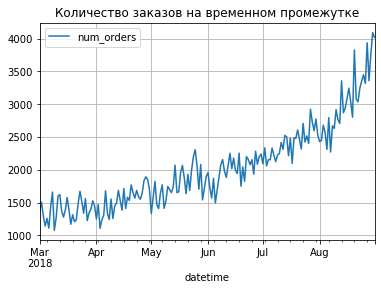

In [7]:
#Для построение данного графика, ресемплирование сделано на 1 день
data.resample('1D').sum().plot(grid=True, 
                               title='Количество заказов на временном промежутке');

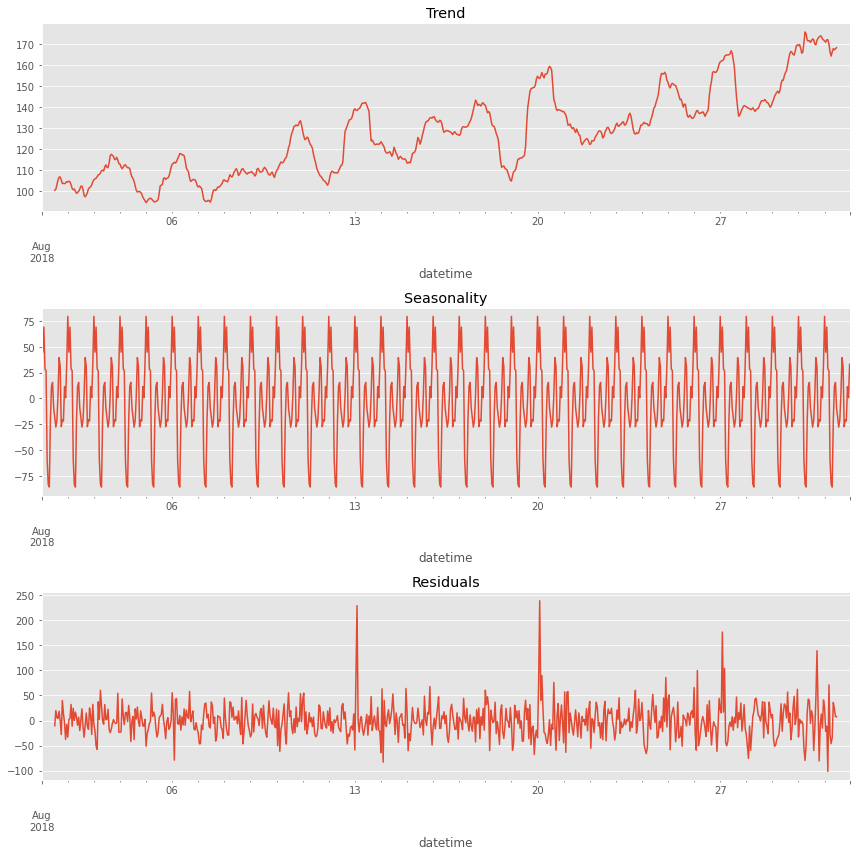

In [8]:
#Разложим временной ряд на тренд и сезонную компоненту
decomposed = seasonal_decompose(data)

#Построим получившиеся графики
plt.style.use('ggplot')
decomposed = seasonal_decompose(data['2018-08':'2018-08'])
plt.figure(figsize=(12, 12))
plt.subplot(311)

decomposed.trend.plot(ax=plt.gca())
plt.title('Trend')
plt.subplot(312)
decomposed.seasonal.plot(ax=plt.gca())

plt.title('Seasonality')
plt.subplot(313)
decomposed.resid.plot(ax=plt.gca())

plt.title('Residuals')
plt.tight_layout()

Наблюдается тред увеличения заказов. В случае сезонности, предварительно сделала ресемплирование по дню, чтобы график стал более информативен, и оказалось, что график стал похож на прямую параллельную оси абсцисс. Поэтому можем утверждать, что на данном промежутке нет зависимости, всё статично и без изменений. То есть такси активно заказывают во все дни недели и вне зависимости от месяца. Но в силу того, что тред растёт, это означает, на данном промежутке плавный рост среднего количества заказов в целом, о чём и говорил график "Количество заказов такси на временном промежутке".

Третий график `Residuals` показывает уровень "шума", то есть те данные, которые не получилось с помощью сезонности и треда.

Теперь обратим внимание на график ниже: "Различные показатели данных на временном ряду". Для лучшей визуализации, данные сгруппировала по дню. Смотря на графики *стандарного отклонения* (`std`) и *разницы между соседними значениями* (`difference_num_orders`), получаем, что они в зависимости от даты они практически не отличаются.

Однако, графики *количество заказов такси* (`num_orders`) и *скользящего среднего* (`mean`) плавно растут с марта по конец августа, что было уже отмечено выше.

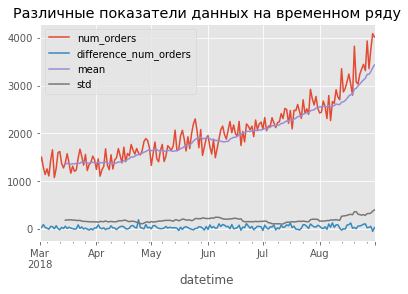

In [9]:
data_dif = data.resample('1D').sum()

data_dif['difference_num_orders'] = data - data.shift()
data_dif['mean'] = data_dif['num_orders'].rolling(15).mean()
data_dif['std'] = data_dif['num_orders'].rolling(15).std()
data_dif.plot(title='Различные показатели данных на временном ряду');

#### Выводы:
В ходе анализа данных было обнаружено, что на данном промежутке (с 1 марта по 31 августа 2018 года) высходящий тред, а по сезонности наоборот нет никаких изменений: то есть такси с одинаковой интенсивностью заказывают во все дни недели вне зависимости от месяца.

Также стоит отметить, что разницы между днями практически нет, что показывает в том числе график выше, а среднее количество заказов плавно растёт вверх.

## Обучение моделей

В данном блоке рассмотрим три модели: *Случайный лес, Линейную регрессию и градиентный бустинг CatBoost*.

Однако прежде, чем перейти непосредственно к обучению моделей, необходимо ещё немного подготовить данные .
В первую очередь добавить в признаки дополнительные данные, которые можно сгруппировать на следующие группы:
- календарные признаки
- отстающие значени
- скользящее среднее

Далее разделить данные на три выборки: тренировочкую, валидационную и тестовую. Соотношение 72%/18%/10% соответсвенно. И только после приступать к обучению каждой из моделей.

In [10]:
#Функция для добавления признаков
def make_features(data, max_lag, rolling_mean_size):
    data['hour'] = data.index.hour
    #data['day'] = data.index.day
    data['dayofweek'] = data.index.dayofweek
    #data['month'] = data.index.month
    
    for lag in range(1, max_lag + 1):
        data['lag_{}'.format(lag)] = data['num_orders'].shift(lag)

    data['rolling_mean'] = data['num_orders'].shift().rolling(rolling_mean_size).mean()
    
#Добавление признаков ко всем данным
make_features(data, 24, 4)

In [11]:
#деление выборки
train, test = train_test_split(data, shuffle=False, test_size=0.1)

#удалим все пропуски
train = train.dropna()

features_train, features_valid, target_train, target_valid = train_test_split(
    train.drop('num_orders', axis=1), train['num_orders'], shuffle=False, test_size=0.2)

features_test = test.drop('num_orders', axis=1)
target_test = test['num_orders']

### Случайный лес

In [12]:
%%time
#Самостоятельный подбор параметров: Случайный лес
best_model_forest = None
best_result_forest = 48
best_est_forest = 0
best_dep_forest = 0

for dep in range(4, 10):
    for est in range(10, 100, 10):
        model = RandomForestRegressor(random_state=RANDOM_STATE, n_estimators=est, max_depth = dep)
        model.fit(features_train, target_train)
        predict = model.predict(features_valid)
        result = mean_squared_error(target_valid, predict) ** 0.5
        
        if result < best_result_forest:
            best_model_forest = model 
            best_result_forest = result
            best_eat_forest = est
            best_dep_forest = dep

print("RMSE наилучшей модели на случайном лесе:", round(best_result_forest))
print('Результат при количестве деревьев:', best_eat_forest)
print('Результат при глубине деревьев:', best_dep_forest)

RMSE наилучшей модели на случайном лесе: 34
Результат при количестве деревьев: 90
Результат при глубине деревьев: 9
CPU times: total: 40.2 s
Wall time: 40.2 s


Результат 33 уже ниже ТЗ (48), что уже хорошо, однако перейдём к следующей модели. Возможно, на следующих моделях получится результат ещё лучше.

### Линейная регрессия

In [13]:
%%time
model_reg = LinearRegression()
model_reg.fit(features_train, target_train)
predict = model_reg.predict(features_valid)
result_reg = mean_squared_error(target_valid, predict) ** 0.5

print('RSME на модели логической регрессии:', round(result_reg))

RSME на модели логической регрессии: 34
CPU times: total: 125 ms
Wall time: 66 ms


Результат такой же, как и у первой модели случайного леса, однако обучение значительно быстрее. Перейдём к модели градиентного бустинга.

### Градиентный бустинг CatBoost

In [14]:
%%time
model_cb = CatBoostRegressor(iterations=100, depth=16, random_state=RANDOM_STATE)
model_cb.fit(features_train, target_train, verbose=10)
predict_cb = model_cb.predict(features_valid)
result_cb = mean_squared_error(target_valid, predict_cb) ** 0.5

print("RMSE модели на CatBoostRegressor:", round(result_cb))

Learning rate set to 0.319249
0:	learn: 29.8764485	total: 2.48s	remaining: 4m 5s
10:	learn: 12.4510147	total: 26.1s	remaining: 3m 31s
20:	learn: 6.7753323	total: 49.9s	remaining: 3m 7s
30:	learn: 3.8704109	total: 1m 13s	remaining: 2m 43s
40:	learn: 2.2168960	total: 1m 37s	remaining: 2m 19s
50:	learn: 1.3171682	total: 2m 1s	remaining: 1m 56s
60:	learn: 0.8072499	total: 2m 25s	remaining: 1m 32s
70:	learn: 0.5050840	total: 2m 48s	remaining: 1m 9s
80:	learn: 0.3623579	total: 3m 11s	remaining: 44.9s
90:	learn: 0.2501160	total: 3m 34s	remaining: 21.3s
99:	learn: 0.1655263	total: 3m 56s	remaining: 0us
RMSE модели на CatBoostRegressor: 40
CPU times: total: 48min 11s
Wall time: 3min 57s


In [15]:
# Функция для вывода результатов трёх моделей
def out_of_res ():
    print('RMSE на трёх моделях')
    print('Случайный лес:', round(best_result_forest))
    print('Линейная регрессия:', round(result_reg))
    print('Градиентный бустинг CatBoost', round(result_cb))

#### Выводы:
На данном этапе данные были ещё немного подготовлены, а именно добавлены признаки (календарные, отстающие значения и скользящие средние) разделены на три части: обучающую, валидационную и тестовую выборки.

После чего были обучены три модели. Ниже представлены результаты метрики `RMSE` на валидационных выборках.

In [16]:
out_of_res()

RMSE на трёх моделях
Случайный лес: 34
Линейная регрессия: 34
Градиентный бустинг CatBoost 40


Каждая из моделей подходит под ТЗ (48), однако лучший результат оказался у двух моделей: Случайный лес и Линейнная регрессия. В связи с тем, что линейная регрессия более быстрая, то финальная проверка будет производиться на ней.

## Проверка на тестовой модели

In [17]:
predict = model_reg.predict(features_test)
result = mean_squared_error(target_test, predict) ** 0.5
print('RMSE Линейной регрессии:', round(result))

RMSE Линейной регрессии: 46


#### Выводы: 
Результат 46 оказался ниже ТЗ (48), а значит основная цель проекта выполнена. Перейдём к общему выводу по всему проекту.

## Выводы

Проект выполнялся для компании «Чётенькое такси», которая собирала исторические данные о заказах такси в аэропортах. Чтобы привлекать больше водителей в период пиковой нагрузки, спрогнозировали количество заказов такси на следующий час. В ходе проекта была построена такая модель на базе Линейной регрессии. Результат метрики `RMSE` на тестовой выборки 46, что подходит под ТЗ. А теперь чуть подробнее о каждом из этапов.

*Проект включал в себя следующие этапы:*

**1) Знакомство и предобработка данных**

Были загружены данные и необходимые библиотеки для дальнейшей работы. Была проведена первая часть предобработки данных, а именно замена индексации на datetime и ресемплирование на 1 час, так как в следующих этапах проекта предстоит делать предсказания на следующий час.

**2) Анализ данных**

В ходе анализа данных было обнаружено, что на данном промежутке (с 1 марта по 31 августа 2018 года) высходящий тред, а по сезонности наоборот нет никаких изменений: то есть такси с одинаковой интенсивностью заказывают во все дни недели вне зависимости от месяца.

Также стоит отметить, что разницы между днями практически нет, что показывает в том числе график выше, а среднее количество заказов плавно растёт вверх.

**3) Обучение моделей**

На данном этапе данные были ещё немного подготовлены, а именно добавлены признаки (календарные, отстающие значения и скользящие средние) разделены на три части: обучающую, валидационную и тестовую выборки.

После чего были обучены три модели. Ниже представлены результаты метрики `RMSE` на валидационных выборках.

In [18]:
out_of_res()

RMSE на трёх моделях
Случайный лес: 34
Линейная регрессия: 34
Градиентный бустинг CatBoost 40


Каждая из моделей подходит под ТЗ (не больше 48), однако лучший результат оказался у двух моделей: Случайный лес и Линейнная регрессия. В связи с тем, что линейная регрессия более быстрая, то финальная проверка будет производиться на ней.

**4) Выбор лучшей модели и её проверка на тестовой выборке**

Была произведена проверка лучшей модели на тестовой выборке: `RMSE`= 46. Результат подходит под требования, поэтому главная цель проекта выполнена.
